# Sentiment Analysis Of Hate Speech and Cyberbullying in Twitter
##### Author: Teng Eileen, Veytri Yogan
##### Source: Twitter
##### Text Exploration Methods: Concordance & N-Gram

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.utils import resample, shuffle

# Download NLTK data
nltk.download('punkt') #divides a text into a list of sentences
nltk.download('stopwords') #efficiently remove stop words
nltk.download('wordnet') # a lexical database of English which groups words together based on their meanings
nltk.download('omw-1.4') #to load wordnet

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Read CSV file of cyberbullying classification dataset
!gdown 1iKVted6TqDRk6cYnP4vuQ-Gix2KPASkO
cyberbullying_tweets = pd.read_csv('/content/cyberbullying_tweets.csv')
#cyberbullying_tweets = pd.read_csv("C:/Users/MyAcer/Desktop/cyberbullying_tweets.csv")

#cyberbullying_tweets = pd.read_csv("C:/Users/teile/OneDrive - Universiti Sains Malaysia/Desktop/TE/Course/Year 3/Sem 1/CPC 353/Assignment/Assignment 1/Datasets/cyberbullying_tweets.csv")
cyberbullying_tweets

Downloading...
From: https://drive.google.com/uc?id=1iKVted6TqDRk6cYnP4vuQ-Gix2KPASkO
To: /content/cyberbullying_tweets.csv
100% 7.17M/7.17M [00:00<00:00, 100MB/s]


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


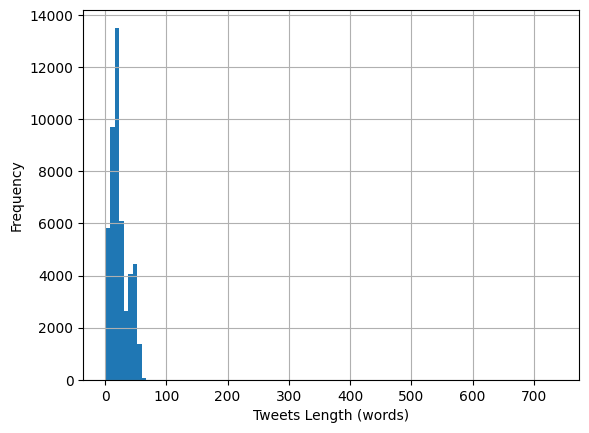

Average words: 23.73450473874025


In [ ]:
# Visualise the number of words for each tweets by splitting them by a space
words_per_tweets = cyberbullying_tweets.tweet_text.apply(lambda x: len(x.split(" ")))
words_per_tweets.hist(bins = 100)
plt.xlabel('Tweets Length (words)')
plt.ylabel('Frequency')
plt.show()

# Display average number of words for all tweets
print('Average words:', words_per_tweets.mean())

In [ ]:
# Display the frequency for each classification
cyberbullying_tweets['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [ ]:
# Split data into two dataframe (positive & negative)
positive_cyberbullying_tweets = cyberbullying_tweets[cyberbullying_tweets['cyberbullying_type'] == 'not_cyberbullying']
negative_cyberbullying_tweets = cyberbullying_tweets[cyberbullying_tweets['cyberbullying_type'] != 'not_cyberbullying']

#positive_cyberbullying_tweets
#negative_cyberbullying_tweets
print("Non-cyberbullying tweets:\n", positive_cyberbullying_tweets['cyberbullying_type'].value_counts())
print("\nCyberbullying tweets:\n", negative_cyberbullying_tweets['cyberbullying_type'].value_counts())

Non-cyberbullying tweets:
 not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

Cyberbullying tweets:
 religion               7998
age                    7992
gender                 7973
ethnicity              7961
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


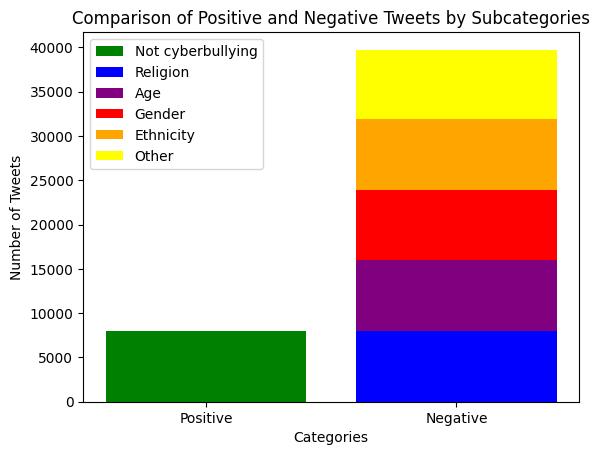

In [ ]:
labels = ['Negative']
positive_count = positive_cyberbullying_tweets.shape[0]
religion_count = negative_cyberbullying_tweets[negative_cyberbullying_tweets['cyberbullying_type'] == 'religion'].shape[0]
age_count = negative_cyberbullying_tweets[negative_cyberbullying_tweets['cyberbullying_type'] == 'age'].shape[0]
gender_count = negative_cyberbullying_tweets[negative_cyberbullying_tweets['cyberbullying_type'] == 'gender'].shape[0]
ethnicity_count = negative_cyberbullying_tweets[negative_cyberbullying_tweets['cyberbullying_type'] == 'ethnicity'].shape[0]
other_count = negative_cyberbullying_tweets[negative_cyberbullying_tweets['cyberbullying_type'] == 'other_cyberbullying'].shape[0]

plt.bar('Positive', positive_count, color='green')
plt.bar(labels, religion_count, color='blue')
plt.bar(labels, age_count, bottom=religion_count, color='purple')
plt.bar(labels, gender_count, bottom=religion_count+age_count, color='red')
plt.bar(labels, ethnicity_count, bottom=religion_count+age_count+gender_count, color='orange')
plt.bar(labels, other_count, bottom=religion_count+age_count+gender_count+ethnicity_count, color='yellow')


plt.xlabel("Categories")
plt.ylabel("Number of Tweets")
plt.legend(["Not cyberbullying", "Religion", "Age", "Gender", "Ethnicity", "Other"])
plt.title("Comparison of Positive and Negative Tweets by Subcategories")

plt.show()

# Upsampling of Data

##### Upsampling involves increasing the number of instances in the minority class to balance it with the majority class. This is typically done by either duplicating existing instances or generating synthetic samples.

### Reasons for upsampling:
#### 1. Imbalanced Data:
##### When the class distribution is skewed, the model may inadequately learn from the minority class, resulting in subpar performance on that class.

#### 2. Improved Model Performance:
##### Balancing the classes can help the model learn the patterns from the minority class more effectively, leading to better overall performance and more accurate predictions.

#### 3. Avoiding Biased Predictions:
##### In cases where the minority class is of particular interest or importance, accurately predicting these instances is crucial, and upsampling can help achieve this.

In [ ]:
# Upsampling non-cyberbullying tweets

seed_num = 0 # set seed value to 0

# Get the frequency of the majority class (cyberbullying)
majority_freq = negative_cyberbullying_tweets['cyberbullying_type'].count()

# Upsample the minority class (non-cyberbullying) with the number of samples equal to the majority class
minor_upsampled = resample(positive_cyberbullying_tweets, replace=True, n_samples=majority_freq, random_state=seed_num)

# Combine the majority class with the upsampled minority class
upsampled = pd.concat([minor_upsampled, negative_cyberbullying_tweets])

# Shuffle the rows in the dataframe, so that the class samples are not grouped together,
# to avoid the model from learning the sequence of the data
upsampled = shuffle(upsampled, random_state=seed_num)

# Then reset the index
upsampled = upsampled.reset_index(drop=True)

# Split the upsampled dataset into two dataframe (positive & negative)
upsampled_positive_tweets = upsampled[upsampled['cyberbullying_type'] == 'not_cyberbullying']
upsampled_negative_tweets = upsampled[upsampled['cyberbullying_type'] != 'not_cyberbullying']

# Display the results dataset after upsampling
print("After upsampling:\n")
print("Non-cyberbullying tweets:\n", upsampled_positive_tweets['cyberbullying_type'].value_counts())
print(upsampled_positive_tweets.shape)

print("\nCyberbullying tweets:\n", upsampled_negative_tweets['cyberbullying_type'].value_counts())
print(upsampled_negative_tweets.shape)

After upsampling:

Non-cyberbullying tweets:
 not_cyberbullying    39747
Name: cyberbullying_type, dtype: int64
(39747, 2)

Cyberbullying tweets:
 religion               7998
age                    7992
gender                 7973
ethnicity              7961
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64
(39747, 2)


## Text Pre-processing
##### Text preprocessing is an essential step in natural language processing (NLP) that involves cleaning and transforming unstructured text data to prepare it for analysis.

#### The steps include :
##### 1. Tokenization
##### 2. Lowercasing
##### 3. Remove special characters
##### 4. Remove stopwords
##### 5. Lemmatization

In [ ]:
# Function for text preprocessing
stop_words = set(stopwords.words('english'))
additional_words = {'a', 'the', 'http', 'co', 'rt'}

stop_words = stop_words.union(additional_words)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def stopwords_removal(stop_words, text):
    return [word for word in nltk.word_tokenize(text) if word not in stop_words] # Tokenize and return non stopwords

def stemm_terms(text):
    return [stemmer.stem(term) for term in text]

def lemmatize_terms(text):
    return [lemmatizer.lemmatize(term) for term in text]

def preprocess(text):
    text = text.str.lower()  # Lowercasing
    tokens = text.str.replace(r'[^A-Za-z0-9 ]+', ' ') # Remove special characters
    tokens = tokens.apply(lambda sentence: stopwords_removal(stop_words, sentence))  # Remove stopwords
    tokens = tokens.apply(lambda sentence: lemmatize_terms(sentence))  # Lemmatization
    return tokens

In [ ]:
# Apply preprocessing to the 'tweet_text' column
upsampled['processed_text'] = preprocess(upsampled['tweet_text'])

In [ ]:
# Display the processed DataFrame
upsampled

,tweet_text,cyberbullying_type,processed_text
0,I basically live inside the Matrix. http://t.c...,not_cyberbullying,"[basically, live, inside, matrix, pvqqxb5huu]"
1,@failedmgc I have a million valid arguments. ...,gender,"[failedmgc, million, valid, argument, change, ..."
2,"Things I hate: 1. Rape jokes 2. Racism 3. ""Gay...",gender,"[thing, hate, 1, rape, joke, 2, racism, 3, gay..."
3,@TURBOCUNT i have no idea what red bean tastes...,not_cyberbullying,"[turbocunt, idea, red, bean, taste, like, assu..."
4,"On this hallowed Mean Girls day, I would like ...",age,"[hallowed, mean, girl, day, would, like, remin..."
...,...,...,...
79489,For fuck sake Annie. Sort out that disgusting ...,not_cyberbullying,"[fuck, sake, annie, sort, disgusting, blush, e..."
79490,#INeedMeninismBecause watching feminists/their...,gender,"[ineedmeninismbecause, watching, feminist, lap..."
79491,@HPluckrose @Feminazi_Front ok. Might have use...,gender,"[hpluckrose, feminazi, front, ok, might, used,..."
79492,Pity the tide didn't come in and sink Annie's ...,gender,"[pity, tide, come, sink, annie, meatball, mkr]"


In [ ]:
# Replace all cyberbullying type other than "not_cyberbullying" to "cyberbullying"
upsampled.loc[upsampled['cyberbullying_type'] != 'not_cyberbullying', 'cyberbullying_type'] = 'cyberbullying'
upsampled

,tweet_text,cyberbullying_type,processed_text
0,I basically live inside the Matrix. http://t.c...,not_cyberbullying,"[basically, live, inside, matrix, pvqqxb5huu]"
1,@failedmgc I have a million valid arguments. ...,cyberbullying,"[failedmgc, million, valid, argument, change, ..."
2,"Things I hate: 1. Rape jokes 2. Racism 3. ""Gay...",cyberbullying,"[thing, hate, 1, rape, joke, 2, racism, 3, gay..."
3,@TURBOCUNT i have no idea what red bean tastes...,not_cyberbullying,"[turbocunt, idea, red, bean, taste, like, assu..."
4,"On this hallowed Mean Girls day, I would like ...",cyberbullying,"[hallowed, mean, girl, day, would, like, remin..."
...,...,...,...
79489,For fuck sake Annie. Sort out that disgusting ...,not_cyberbullying,"[fuck, sake, annie, sort, disgusting, blush, e..."
79490,#INeedMeninismBecause watching feminists/their...,cyberbullying,"[ineedmeninismbecause, watching, feminist, lap..."
79491,@HPluckrose @Feminazi_Front ok. Might have use...,cyberbullying,"[hpluckrose, feminazi, front, ok, might, used,..."
79492,Pity the tide didn't come in and sink Annie's ...,cyberbullying,"[pity, tide, come, sink, annie, meatball, mkr]"


In [ ]:
# Exporting the processed text to a new CSV file
# The file will be saved in the same directory as the notebook file
upsampled.to_csv('processed_tweets.csv', index=False)

## Keyword Extraction

### Keywords and a representative word cloud is created to display the word which most frequently appears from the "cyberbullying" class

In [ ]:
import spacy
# Extract only rows that is cyberbullying tweets
upsampled_cyberbullying = upsampled[upsampled['cyberbullying_type'] == 'cyberbullying']
text_column = upsampled_cyberbullying['processed_text']
text = ' '.join(text_column.astype(str))
max_length = 1000000
text = text[:max_length]

# Load the Spacy model and create a new document
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

# Use the noun_chunks property of the document to identify the noun phrases in the text
noun_phrases = [chunk.text for chunk in doc.noun_chunks]

# Use term frequency-inverse document frequency (TF-IDF) analysis to rank the noun phrases
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform([doc.text])

# Get the top 10 most important noun phrases
top_phrases = sorted(vectorizer.vocabulary_, key=lambda x: tfidf[0, vectorizer.vocabulary_[x]], reverse=True)[:10]

# Print the top 10 keywords
print("Top 10 keywords: ", top_phrases)

Top 10 keywords:  ['school', 'fuck', 'nigger', 'joke', 'dumb', 'girl', 'like', 'muslim', 'bully', 'high']


## Wordcloud

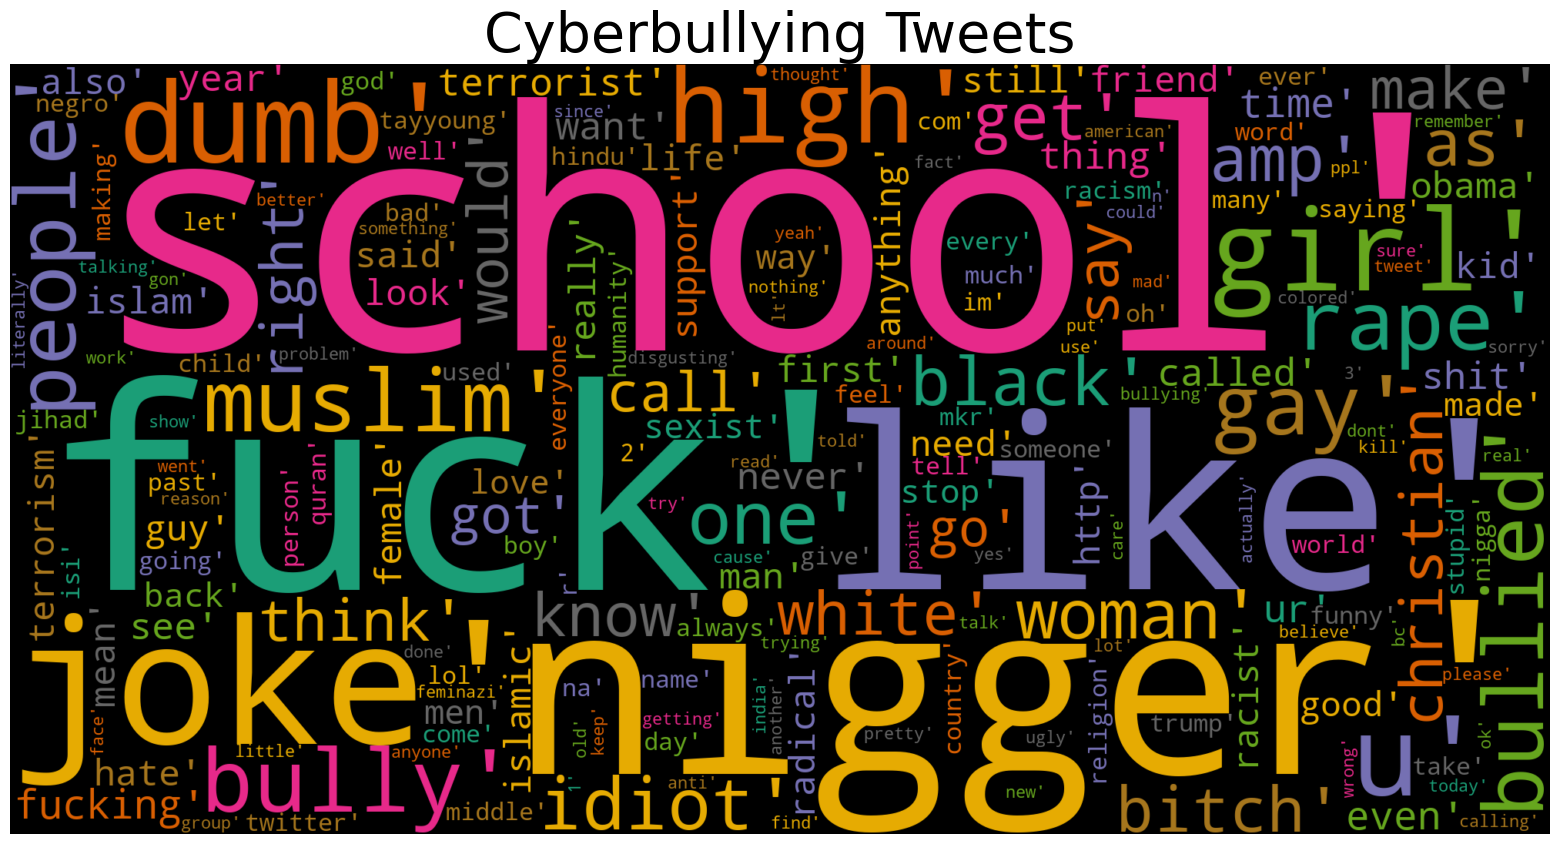

In [ ]:
import matplotlib.pyplot as plt
#!pip install wordcloud

from wordcloud import WordCloud, ImageColorGenerator
plt.figure(figsize=(20,10))
text_cyberbullying = " ".join(upsampled_cyberbullying.processed_text.astype(str))
cloud1=WordCloud(background_color='black',colormap="Dark2", collocations=False,width=2000,height=1000).generate(text_cyberbullying)

plt.axis('off')
plt.title("Cyberbullying Tweets",fontsize=40)
plt.imshow(cloud1, interpolation='bilinear')

# N-Gram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from termcolor import colored

# Load the CSV file into a DataFrame
df = pd.read_csv('processed_tweets.csv')
text_data = df['processed_text']

# Filter the dataset for cyberbullying and not_cyberbullying classes
cyberbullying_data = df[df['cyberbullying_type'] == 'cyberbullying']
not_cyberbullying_data = df[df['cyberbullying_type'] == 'not_cyberbullying']

# Function to perform n-gram analysis
def perform_ngram_analysis(data, ngram_range):
    # Assuming 'processed_text' is the column containing processed text
    text_data = data['processed_text']

    # Initialize CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range)

    # Fit and transform the text data using the vectorizer
    matrix = vectorizer.fit_transform(text_data)

    # Get feature names (n-grams) from the vectorizer
    features = vectorizer.get_feature_names_out()

    # Calculate the total counts for each n-gram
    counts = matrix.sum(axis=0).A1

    # Create a DataFrame for n-grams
    ngram_df = pd.DataFrame({'Ngram': features, 'Frequency': counts})

    # Sort and get the top 10 most common n-grams
    top_10_ngrams = ngram_df.nlargest(10, 'Frequency')

    return top_10_ngrams

### Unigram - Class (Cyberbullying) → Negative

In [ ]:
# Perform analysis for unigram for cyberbullying class
cyberbullying_unigrams = perform_ngram_analysis(cyberbullying_data, (1, 1))

# Display the results
print("Cyberbullying Unigrams:")
print(cyberbullying_unigrams.to_string(index=False))

Cyberbullying Unigrams:
 Ngram  Frequency
school       8920
  fuck       6084
nigger       5817
  like       5626
  joke       5607
  girl       5498
  dumb       5381
  high       5211
 bully       5017
muslim       4945


### Bigram - Class (Cyberbullying) → Negative

In [ ]:
# Perform analysis for bigram for cyberbullying class
cyberbullying_bigrams = perform_ngram_analysis(cyberbullying_data, (2, 2))

# Display the results
print("Cyberbullying Bigrams:")
print(cyberbullying_bigrams.to_string(index=False))

Cyberbullying Bigrams:
       Ngram  Frequency
 high school       4699
   rape joke       2287
     dumb as       1551
girl bullied       1396
bullied high       1350
   as nigger       1338
school bully       1216
 dumb nigger       1205
   dumb fuck       1073
  fuck obama       1000


### Trigram - Class (Cyberbullying) → Negative

In [ ]:
# Perform analysis for trigram for cyberbullying class
cyberbullying_trigrams = perform_ngram_analysis(cyberbullying_data, (3, 3))

# Display the results
print("Cyberbullying Trigrams:")
print(cyberbullying_trigrams.to_string(index=False))

Cyberbullying Trigrams:
              Ngram  Frequency
bullied high school       1343
     dumb as nigger       1216
    fuck obama dumb        979
      obama dumb as        965
tayyoung fuck obama        956
  girl bullied high        825
  high school bully        440
   girl high school        415
   fuck dumb nigger        385
      gay rape joke        308
